# Fish Disease Classification - Machine Learning Pipeline

## Overview
This notebook implements a comprehensive ML pipeline for classifying fish disease into 10 classes (0-9) using tabular features extracted from images.

**Models**: Random Forest (primary), Decision Tree, KNN  
**Techniques**: PCA, Feature Selection (SelectKBest), Cross-Validation, Hyperparameter Tuning  
**Deliverables**: model_1.pkl, visualizations, comprehensive report


In [1]:
# ============================================================================
# HEADER: Imports, Seed, File Paths, Helper Functions
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, learning_curve, cross_val_score
)
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc,
    roc_auc_score
)
import joblib
import time
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RND = 42
np.random.seed(RND)

# File paths
TRAIN_PATH = 'fish_disease_train.csv'
TEST_PATH = 'fish_disease_test.csv'
MODEL_PATH = 'model_1.pkl'
FIGURES_DIR = 'figures'

# Create figures directory if it doesn't exist
os.makedirs(FIGURES_DIR, exist_ok=True)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports and setup complete")
print(f"✓ Random seed set to {RND}")
print(f"✓ Figures directory: {FIGURES_DIR}")


✓ Imports and setup complete
✓ Random seed set to 42
✓ Figures directory: figures


## 1. Data Loading & Exploratory Data Analysis


In [2]:
# Load training and test datasets
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print("=" * 60)
print("DATASET SUMMARY")
print("=" * 60)
print(f"\nTraining set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"\nTraining set columns:\n{train_df.columns.tolist()}")
print(f"\nTraining set dtypes:\n{train_df.dtypes}")
print(f"\nTraining set info:")
train_df.info()


DATASET SUMMARY

Training set shape: (7967, 15)
Test set shape: (1992, 15)

Training set columns:
['Entropy', 'Contrast', 'Energy', 'Homogeneity', 'Correlation', 'Dissimilarity', 'Average_R', 'Average_G', 'Average_B', 'Mean', 'Std Dev', 'Variance', 'Kurtosis', 'Skewness', 'Class']

Training set dtypes:
Entropy          float64
Contrast         float64
Energy           float64
Homogeneity      float64
Correlation      float64
Dissimilarity    float64
Average_R        float64
Average_G        float64
Average_B        float64
Mean             float64
Std Dev          float64
Variance         float64
Kurtosis         float64
Skewness         float64
Class              int64
dtype: object

Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7967 entries, 0 to 7966
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Entropy        7967 non-null   float64
 1   Contrast       7967 non-null   float64
 2  

In [3]:
# Check for missing values
print("=" * 60)
print("MISSING VALUES CHECK")
print("=" * 60)
print("\nTraining set missing values:")
missing_train = train_df.isnull().sum()
print(missing_train[missing_train > 0] if missing_train.sum() > 0 else "No missing values found")

print("\nTest set missing values:")
missing_test = test_df.isnull().sum()
print(missing_test[missing_test > 0] if missing_test.sum() > 0 else "No missing values found")

# Display first few rows
print("\n" + "=" * 60)
print("TRAINING SET HEAD")
print("=" * 60)
display(train_df.head())


MISSING VALUES CHECK

Training set missing values:
No missing values found

Test set missing values:
No missing values found

TRAINING SET HEAD


,Entropy,Contrast,Energy,Homogeneity,Correlation,Dissimilarity,Average_R,Average_G,Average_B,Mean,Std Dev,Variance,Kurtosis,Skewness,Class
0,3.089044,103.484474,0.715319,0.751992,0.988201,3.525075,133.927888,134.124637,122.583450,36.333672,66.270070,4391.722207,3.987488,1.570458,9
1,0.173448,8.590868,0.988954,0.992453,0.976619,0.097429,189.096533,127.788239,71.194086,1.148008,13.838293,191.498341,166.917837,12.609277,3
2,0.444434,8.979343,0.963752,0.975923,0.951181,0.227418,42.653656,38.407018,39.996562,1.112086,9.721199,94.501712,143.855685,11.278587,1
3,0.308950,9.696244,0.977235,0.982782,0.976515,0.248347,72.558788,89.174254,93.234549,1.565753,14.237728,202.712904,125.096421,10.528541,0
4,0.892447,12.352270,0.926267,0.943913,0.989706,0.487507,89.285731,84.507989,77.357355,5.893133,24.603154,605.315202,24.686244,4.585030,0


In [4]:
# Separate features (X) and labels (y)
# Last column is the class label
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Class distribution
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION - TRAINING SET")
print("=" * 60)
class_counts = y_train.value_counts().sort_index()
print(class_counts)
print(f"\nTotal samples: {len(y_train)}")
print(f"Number of classes: {len(class_counts)}")
print(f"Class balance ratio (min/max): {class_counts.min() / class_counts.max():.3f}")


Training features shape: (7967, 14)
Training labels shape: (7967,)
Test features shape: (1992, 14)
Test labels shape: (1992,)

CLASS DISTRIBUTION - TRAINING SET
Class
0     664
1    1086
2     852
3    1352
4     797
5     554
6     782
7     358
8     448
9    1074
Name: count, dtype: int64

Total samples: 7967
Number of classes: 10
Class balance ratio (min/max): 0.265


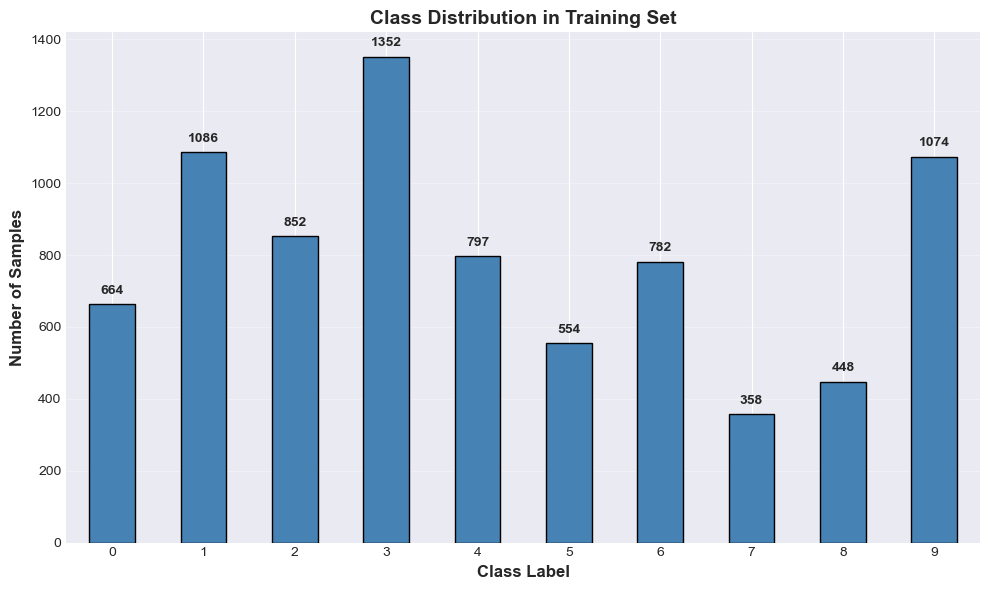

✓ Class distribution plot saved


In [5]:
# Visualize class distribution
fig, ax = plt.subplots(figsize=(10, 6))
class_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Class Label', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution in Training Set', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(class_counts):
    ax.text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Class distribution plot saved")


In [6]:
# Statistical summary of features
print("=" * 60)
print("FEATURE STATISTICS SUMMARY")
print("=" * 60)
display(X_train.describe())


FEATURE STATISTICS SUMMARY


,Entropy,Contrast,Energy,Homogeneity,Correlation,Dissimilarity,Average_R,Average_G,Average_B,Mean,Std Dev,Variance,Kurtosis,Skewness
count,7967.000000,7967.000000,7967.000000,7967.000000,7967.000000,7967.000000,7967.000000,7967.000000,7967.000000,7967.000000,7967.000000,7967.000000,7967.000000,7967.000000
mean,2.222886,38.931241,0.776910,0.846132,0.987186,1.280451,117.165562,106.037464,94.289301,23.034242,42.173318,2142.859132,25.306812,3.598604
std,1.677508,44.713150,0.195839,0.134906,0.011334,1.296208,40.540463,29.675955,33.420915,22.536869,19.087067,1774.704907,44.203438,3.035590
min,0.049853,1.235598,0.045283,0.288351,0.888934,0.028019,24.288282,21.860880,6.642548,0.183133,4.046896,16.377366,1.238923,-0.690582
25%,0.839781,15.179110,0.679264,0.780700,0.983980,0.434886,85.753624,85.548695,71.153248,6.009246,26.871280,722.065676,4.044270,1.488253
50%,1.796992,27.233222,0.837295,0.886173,0.990785,0.885058,113.608087,104.746727,93.061861,15.690372,41.293857,1705.182647,9.757016,2.723007
75%,3.210627,46.455698,0.932488,0.951546,0.994244,1.662885,146.814227,126.255530,115.029308,31.567633,55.841307,3118.251519,27.171862,4.800967
max,7.573361,711.544374,0.997095,0.997904,0.998970,14.284569,238.778216,201.653908,221.475372,132.280814,105.325599,11093.481810,622.617208,24.163986


## 2. Preprocessing Pipeline


In [7]:
# Create preprocessing pipeline
# Since we checked for missing values, we'll include imputation as a safety measure
# StandardScaler will standardize all features

preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle any potential missing values
    ('scaler', StandardScaler())  # Standardize features
])

print("✓ Preprocessing pipeline created")
print("Pipeline steps:")
for name, step in preprocessing_pipeline.steps:
    print(f"  - {name}: {type(step).__name__}")


✓ Preprocessing pipeline created
Pipeline steps:
  - imputer: SimpleImputer
  - scaler: StandardScaler


## 3. Model 1: Random Forest Classifier

### 3.1 Hyperparameter Tuning with GridSearchCV


In [8]:
# Create Random Forest pipeline
rf_pipeline = Pipeline([
    ('preproc', preprocessing_pipeline),
    ('clf', RandomForestClassifier(random_state=RND, n_jobs=-1))
])

# Define hyperparameter grid for Random Forest
param_grid_rf = {
    'clf__n_estimators': [100, 200, 500],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2', 0.2, 0.5]
}

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)

print("=" * 60)
print("RANDOM FOREST HYPERPARAMETER TUNING")
print("=" * 60)
print(f"CV strategy: {cv.n_splits}-fold StratifiedKFold")
print(f"Parameter grid size: {np.prod([len(v) for v in param_grid_rf.values()])} combinations")
print("\nStarting GridSearchCV...")

# Perform grid search
start_time = time.time()
grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid_rf,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_train, y_train)
tuning_time = time.time() - start_time

print(f"\n✓ GridSearchCV completed in {tuning_time:.2f} seconds")
print(f"\nBest parameters:")
for param, value in grid_search_rf.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV score: {grid_search_rf.best_score_:.4f}")


RANDOM FOREST HYPERPARAMETER TUNING
CV strategy: 5-fold StratifiedKFold
Parameter grid size: 144 combinations

Starting GridSearchCV...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

✓ GridSearchCV completed in 1184.24 seconds

Best parameters:
  clf__max_depth: None
  clf__max_features: 0.2
  clf__min_samples_leaf: 1
  clf__n_estimators: 500

Best CV score: 0.9740


In [9]:
# Train final model on full training set with best parameters
print("\n" + "=" * 60)
print("TRAINING FINAL RANDOM FOREST MODEL")
print("=" * 60)

start_time = time.time()
final_rf_model = grid_search_rf.best_estimator_
final_rf_model.fit(X_train, y_train)
training_time_rf = time.time() - start_time

print(f"✓ Model trained in {training_time_rf:.2f} seconds")

# Save the model
joblib.dump(final_rf_model, MODEL_PATH)
print(f"✓ Model saved to {MODEL_PATH}")

# Verify model can be loaded
loaded_model = joblib.load(MODEL_PATH)
print(f"✓ Model verification: Successfully loaded from {MODEL_PATH}")



TRAINING FINAL RANDOM FOREST MODEL
✓ Model trained in 4.17 seconds
✓ Model saved to model_1.pkl
✓ Model verification: Successfully loaded from model_1.pkl


In [10]:
# Cross-validated performance on training set
print("\n" + "=" * 60)
print("CROSS-VALIDATED PERFORMANCE (5-Fold Stratified)")
print("=" * 60)

cv_scores_accuracy = cross_val_score(final_rf_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
cv_scores_f1_macro = cross_val_score(final_rf_model, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)

print(f"\nAccuracy: {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
print(f"Macro F1-score: {cv_scores_f1_macro.mean():.4f} (+/- {cv_scores_f1_macro.std() * 2:.4f})")
print(f"\nPer-fold accuracy: {cv_scores_accuracy}")
print(f"Per-fold macro F1: {cv_scores_f1_macro}")



CROSS-VALIDATED PERFORMANCE (5-Fold Stratified)

Accuracy: 0.9740 (+/- 0.0060)
Macro F1-score: 0.9759 (+/- 0.0067)

Per-fold accuracy: [0.96925972 0.97427854 0.97363465 0.97865662 0.9742624 ]
Per-fold macro F1: [0.97135152 0.97332365 0.97596245 0.9805506  0.97853293]


### 3.2 Test Set Evaluation


In [11]:
# Load model and predict on test set
print("=" * 60)
print("TEST SET EVALUATION - RANDOM FOREST")
print("=" * 60)

# Use loaded model for demonstration
start_time = time.time()
y_pred_rf = loaded_model.predict(X_test)
prediction_time_rf = time.time() - start_time

print(f"✓ Predictions completed in {prediction_time_rf:.4f} seconds")

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_macro_rf = precision_score(y_test, y_pred_rf, average='macro', zero_division=0)
precision_micro_rf = precision_score(y_test, y_pred_rf, average='micro', zero_division=0)
precision_weighted_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
recall_macro_rf = recall_score(y_test, y_pred_rf, average='macro', zero_division=0)
recall_micro_rf = recall_score(y_test, y_pred_rf, average='micro', zero_division=0)
recall_weighted_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
f1_macro_rf = f1_score(y_test, y_pred_rf, average='macro', zero_division=0)
f1_micro_rf = f1_score(y_test, y_pred_rf, average='micro', zero_division=0)
f1_weighted_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

print(f"\nOverall Accuracy: {accuracy_rf:.4f}")
print(f"\nPrecision (macro): {precision_macro_rf:.4f}")
print(f"Precision (micro): {precision_micro_rf:.4f}")
print(f"Precision (weighted): {precision_weighted_rf:.4f}")
print(f"\nRecall (macro): {recall_macro_rf:.4f}")
print(f"Recall (micro): {recall_micro_rf:.4f}")
print(f"Recall (weighted): {recall_weighted_rf:.4f}")
print(f"\nF1-score (macro): {f1_macro_rf:.4f}")
print(f"F1-score (micro): {f1_micro_rf:.4f}")
print(f"F1-score (weighted): {f1_weighted_rf:.4f}")


TEST SET EVALUATION - RANDOM FOREST
✓ Predictions completed in 0.7941 seconds

Overall Accuracy: 0.9799

Precision (macro): 0.9786
Precision (micro): 0.9799
Precision (weighted): 0.9801

Recall (macro): 0.9834
Recall (micro): 0.9799
Recall (weighted): 0.9799

F1-score (macro): 0.9809
F1-score (micro): 0.9799
F1-score (weighted): 0.9799


In [12]:
# Class-wise performance metrics
print("\n" + "=" * 60)
print("CLASS-WISE PERFORMANCE METRICS")
print("=" * 60)

class_report = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
class_report_df = pd.DataFrame(class_report).transpose()
display(class_report_df.round(4))



CLASS-WISE PERFORMANCE METRICS


,precision,recall,f1-score,support
0,0.9565,0.9935,0.9747,155.0000
1,0.9863,0.9600,0.9730,300.0000
2,0.9952,1.0000,0.9976,208.0000
3,0.9713,0.9652,0.9683,316.0000
4,0.9955,1.0000,0.9978,223.0000
5,0.9481,0.9697,0.9588,132.0000
6,0.9894,0.9738,0.9815,191.0000
7,1.0000,1.0000,1.0000,102.0000
8,0.9597,1.0000,0.9794,119.0000
9,0.9835,0.9715,0.9775,246.0000


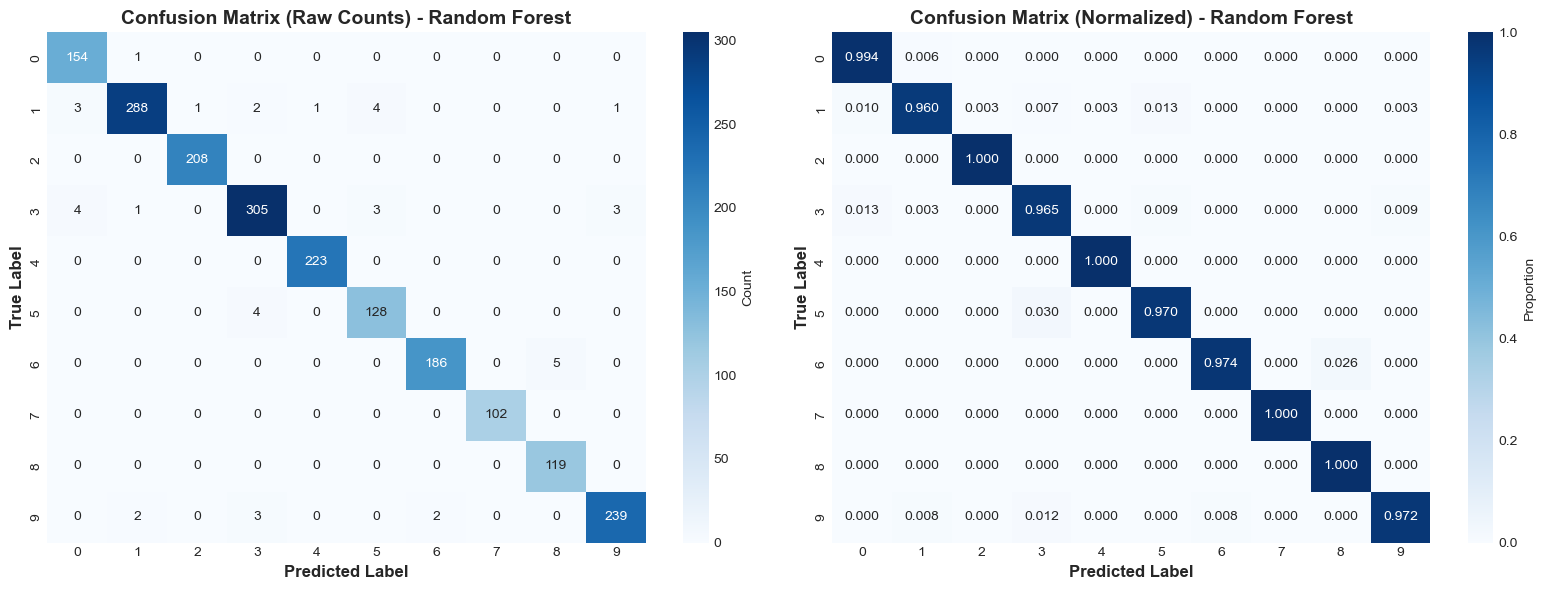

✓ Confusion matrix plots saved


In [13]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_normalized = confusion_matrix(y_test, y_pred_rf, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw confusion matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=range(10), yticklabels=range(10), cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_title('Confusion Matrix (Raw Counts) - Random Forest', fontsize=14, fontweight='bold')

# Normalized confusion matrix
sns.heatmap(cm_rf_normalized, annot=True, fmt='.3f', cmap='Blues', ax=axes[1],
            xticklabels=range(10), yticklabels=range(10), cbar_kws={'label': 'Proportion'})
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_title('Confusion Matrix (Normalized) - Random Forest', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/confusion_matrix_rf.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix plots saved")


### 3.3 ROC-AUC for Multiclass Classification


In [14]:
# Get prediction probabilities for ROC curves
y_pred_proba_rf = loaded_model.predict_proba(X_test)

# Binarize labels for One-vs-Rest ROC
label_binarizer = LabelBinarizer()
y_test_bin = label_binarizer.fit_transform(y_test)

# Compute ROC curve and AUC for each class
n_classes = len(np.unique(y_test))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba_rf.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and AUC
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print("=" * 60)
print("ROC-AUC SCORES - RANDOM FOREST")
print("=" * 60)
print(f"\nPer-class AUC:")
for i in range(n_classes):
    print(f"  Class {i}: {roc_auc[i]:.4f}")
print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:.4f}")


ROC-AUC SCORES - RANDOM FOREST

Per-class AUC:
  Class 0: 0.9999
  Class 1: 0.9996
  Class 2: 1.0000
  Class 3: 0.9988
  Class 4: 1.0000
  Class 5: 0.9998
  Class 6: 0.9999
  Class 7: 1.0000
  Class 8: 1.0000
  Class 9: 0.9997

Micro-average AUC: 0.9998
Macro-average AUC: 0.9998


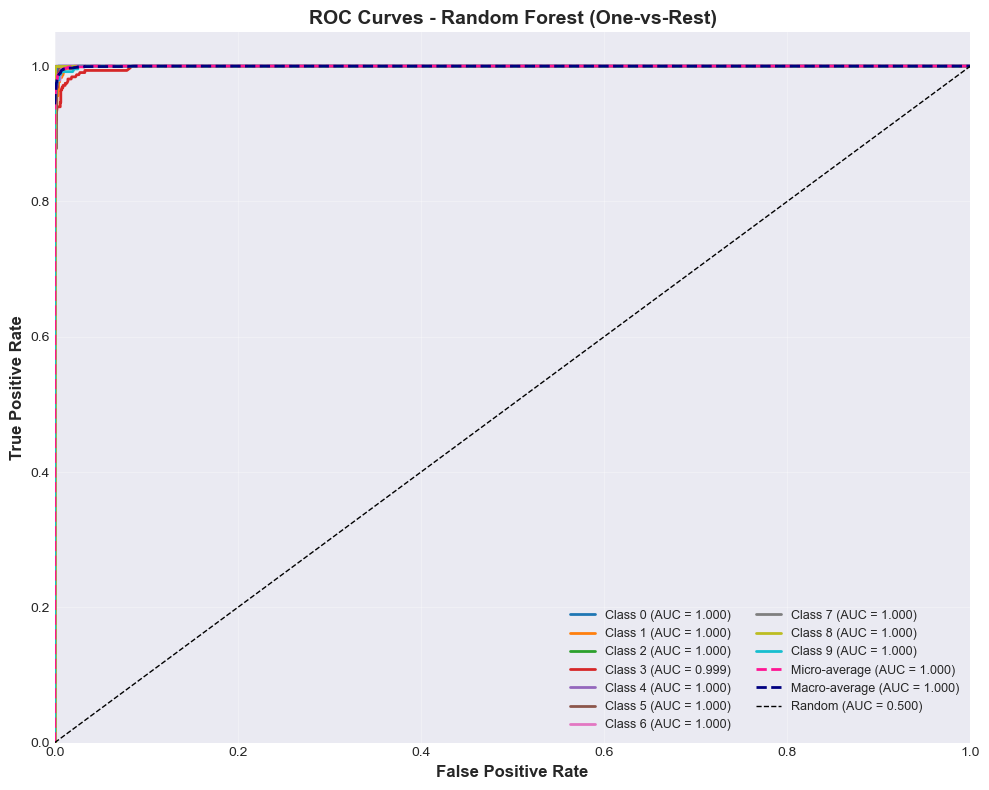

✓ ROC curves plot saved


In [15]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(10, 8))

# Plot ROC curves for all classes
colors = plt.cm.get_cmap('tab10', n_classes)
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], color=colors(i), lw=2,
            label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Plot micro and macro averages
ax.plot(fpr["micro"], tpr["micro"],
        label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
        color='deeppink', linestyle='--', linewidth=2)
ax.plot(fpr["macro"], tpr["macro"],
        label=f'Macro-average (AUC = {roc_auc["macro"]:.3f})',
        color='navy', linestyle='--', linewidth=2)

# Plot diagonal line (random classifier)
ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.500)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - Random Forest (One-vs-Rest)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=9, ncol=2)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/roc_curves_rf.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC curves plot saved")


## 4. Dimensionality Reduction Experiments

### 4.1 Principal Component Analysis (PCA)


PCA ANALYSIS

Total features: 14
Components needed for 95% variance: 6

Explained variance ratio (first 10 components):
  PC1: 0.5458
  PC2: 0.1789
  PC3: 0.1168
  PC4: 0.0616
  PC5: 0.0455
  PC6: 0.0188
  PC7: 0.0145
  PC8: 0.0083
  PC9: 0.0044
  PC10: 0.0031

Cumulative variance (first 10 components):
  PC1: 0.5458
  PC2: 0.7247
  PC3: 0.8415
  PC4: 0.9031
  PC5: 0.9486
  PC6: 0.9674
  PC7: 0.9819
  PC8: 0.9902
  PC9: 0.9946
  PC10: 0.9977


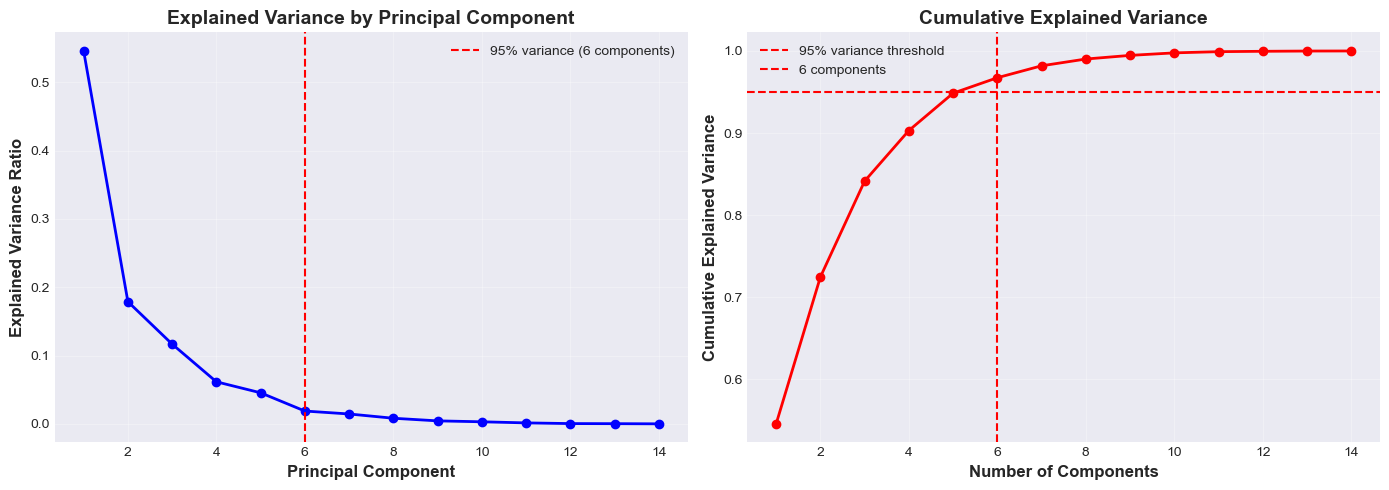

✓ PCA variance analysis plot saved


In [16]:
# Fit PCA on training data to analyze explained variance
X_train_scaled = preprocessing_pipeline.fit_transform(X_train)

pca_full = PCA()
pca_full.fit(X_train_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print("=" * 60)
print("PCA ANALYSIS")
print("=" * 60)
print(f"\nTotal features: {X_train_scaled.shape[1]}")
print(f"Components needed for 95% variance: {n_components_95}")
print(f"\nExplained variance ratio (first 10 components):")
for i in range(min(10, len(pca_full.explained_variance_ratio_))):
    print(f"  PC{i+1}: {pca_full.explained_variance_ratio_[i]:.4f}")
print(f"\nCumulative variance (first 10 components):")
for i in range(min(10, len(cumulative_variance))):
    print(f"  PC{i+1}: {cumulative_variance[i]:.4f}")

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
              pca_full.explained_variance_ratio_, 'bo-', linewidth=2, markersize=6)
axes[0].axvline(x=n_components_95, color='r', linestyle='--', label=f'95% variance ({n_components_95} components)')
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[0].set_title('Explained Variance by Principal Component', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-', linewidth=2, markersize=6)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% variance threshold')
axes[1].axvline(x=n_components_95, color='r', linestyle='--', label=f'{n_components_95} components')
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/pca_variance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ PCA variance analysis plot saved")


In [20]:
# Extract best RF parameters (remove 'clf__' prefix)
rf_best_params = {k.replace('clf__', ''): v for k, v in grid_search_rf.best_params_.items() if k.startswith('clf__')}

# Get number of features for validation
n_features = X_train.shape[1]
print(f"Number of features: {n_features}")

# Test PCA with different component counts (must be <= n_features)
pca_configs = [
    ('PCA_95var', PCA(n_components=0.95)),  # 95% variance
    ('PCA_5', PCA(n_components=5)),
    ('PCA_10', PCA(n_components=min(10, n_features)))  # Use min to ensure valid
]

pca_results = []

for name, pca in pca_configs:
    print(f"\n{'='*60}")
    print(f"Testing {name}")
    print(f"{'='*60}")
    
    # Create pipeline with PCA
    rf_pipeline_pca = Pipeline([
        ('preproc', preprocessing_pipeline),
        ('pca', pca),
        ('clf', RandomForestClassifier(**rf_best_params, random_state=RND, n_jobs=-1))
    ])
    
    # Train
    start_time = time.time()
    rf_pipeline_pca.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predict
    start_time = time.time()
    y_pred_pca = rf_pipeline_pca.predict(X_test)
    pred_time = time.time() - start_time
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred_pca)
    f1_macro = f1_score(y_test, y_pred_pca, average='macro', zero_division=0)
    
    # Get actual number of components used
    n_comp = rf_pipeline_pca.named_steps['pca'].n_components_
    
    pca_results.append({
        'Method': name,
        'N_Components': n_comp,
        'Accuracy': accuracy,
        'F1_Macro': f1_macro,
        'Train_Time': train_time,
        'Pred_Time': pred_time
    })
    
    print(f"Components: {n_comp}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Macro: {f1_macro:.4f}")
    print(f"Training time: {train_time:.4f}s")
    print(f"Prediction time: {pred_time:.4f}s")

pca_results_df = pd.DataFrame(pca_results)
print("\n" + "="*60)
print("PCA RESULTS SUMMARY")
print("="*60)
display(pca_results_df)


Number of features: 14

Testing PCA_95var
Components: 6
Accuracy: 0.9202
F1-Macro: 0.9264
Training time: 3.0700s
Prediction time: 0.5056s

Testing PCA_5
Components: 5
Accuracy: 0.9217
F1-Macro: 0.9250
Training time: 2.7904s
Prediction time: 0.6013s

Testing PCA_10
Components: 10
Accuracy: 0.9553
F1-Macro: 0.9583
Training time: 3.1126s
Prediction time: 0.4505s

PCA RESULTS SUMMARY


,Method,N_Components,Accuracy,F1_Macro,Train_Time,Pred_Time
0,PCA_95var,6,0.920181,0.926354,3.070018,0.505606
1,PCA_5,5,0.921687,0.925007,2.790365,0.601273
2,PCA_10,10,0.955321,0.958327,3.112592,0.450533


### 4.2 Feature Selection with SelectKBest


In [21]:
# Test SelectKBest with different k values (must be <= n_features)
kbest_configs = [
    ('KBest_5', SelectKBest(f_classif, k=5)),
    ('KBest_10', SelectKBest(f_classif, k=10)),
    ('KBest_all', SelectKBest(f_classif, k='all'))
]

kbest_results = []

for name, selector in kbest_configs:
    print(f"\n{'='*60}")
    print(f"Testing {name}")
    print(f"{'='*60}")
    
    # Create pipeline with SelectKBest
    rf_pipeline_kbest = Pipeline([
        ('preproc', preprocessing_pipeline),
        ('selector', selector),
        ('clf', RandomForestClassifier(**rf_best_params, random_state=RND, n_jobs=-1))
    ])
    
    # Train
    start_time = time.time()
    rf_pipeline_kbest.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predict
    start_time = time.time()
    y_pred_kbest = rf_pipeline_kbest.predict(X_test)
    pred_time = time.time() - start_time
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred_kbest)
    f1_macro = f1_score(y_test, y_pred_kbest, average='macro', zero_division=0)
    
    # Get actual number of features selected
    n_features = rf_pipeline_kbest.named_steps['selector'].n_features_in_ if selector.k == 'all' else selector.k
    
    kbest_results.append({
        'Method': name,
        'N_Features': n_features,
        'Accuracy': accuracy,
        'F1_Macro': f1_macro,
        'Train_Time': train_time,
        'Pred_Time': pred_time
    })
    
    print(f"Features selected: {n_features}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Macro: {f1_macro:.4f}")
    print(f"Training time: {train_time:.4f}s")
    print(f"Prediction time: {pred_time:.4f}s")
    
    # Show selected features for k=5 case
    if selector.k == 5:
        selected_features = X_train.columns[rf_pipeline_kbest.named_steps['selector'].get_support()].tolist()
        print(f"\nSelected features: {selected_features}")

kbest_results_df = pd.DataFrame(kbest_results)
print("\n" + "="*60)
print("SELECTKBEST RESULTS SUMMARY")
print("="*60)
display(kbest_results_df)



Testing KBest_5
Features selected: 5
Accuracy: 0.9573
F1-Macro: 0.9590
Training time: 3.0471s
Prediction time: 0.6147s

Selected features: ['Entropy', 'Energy', 'Homogeneity', 'Mean', 'Skewness']

Testing KBest_10
Features selected: 10
Accuracy: 0.9754
F1-Macro: 0.9771
Training time: 3.2501s
Prediction time: 0.6182s

Testing KBest_all
Features selected: 14
Accuracy: 0.9799
F1-Macro: 0.9809
Training time: 3.0662s
Prediction time: 0.5228s

SELECTKBEST RESULTS SUMMARY


,Method,N_Features,Accuracy,F1_Macro,Train_Time,Pred_Time
0,KBest_5,5,0.957329,0.959006,3.047050,0.614695
1,KBest_10,10,0.975402,0.977094,3.250121,0.618215
2,KBest_all,14,0.979920,0.980854,3.066213,0.522789


DIMENSIONALITY REDUCTION COMPARISON


,Method,N_Components,Accuracy,F1_Macro,Train_Time,Pred_Time,N_Features
0,Baseline (No Reduction),14.0,0.9799,0.9809,4.1739,0.7941,NaN
1,PCA_95var,6.0,0.9202,0.9264,3.0700,0.5056,NaN
2,PCA_5,5.0,0.9217,0.9250,2.7904,0.6013,NaN
3,PCA_10,10.0,0.9553,0.9583,3.1126,0.4505,NaN
4,KBest_5,NaN,0.9573,0.9590,3.0471,0.6147,5.0
5,KBest_10,NaN,0.9754,0.9771,3.2501,0.6182,10.0
6,KBest_all,NaN,0.9799,0.9809,3.0662,0.5228,14.0


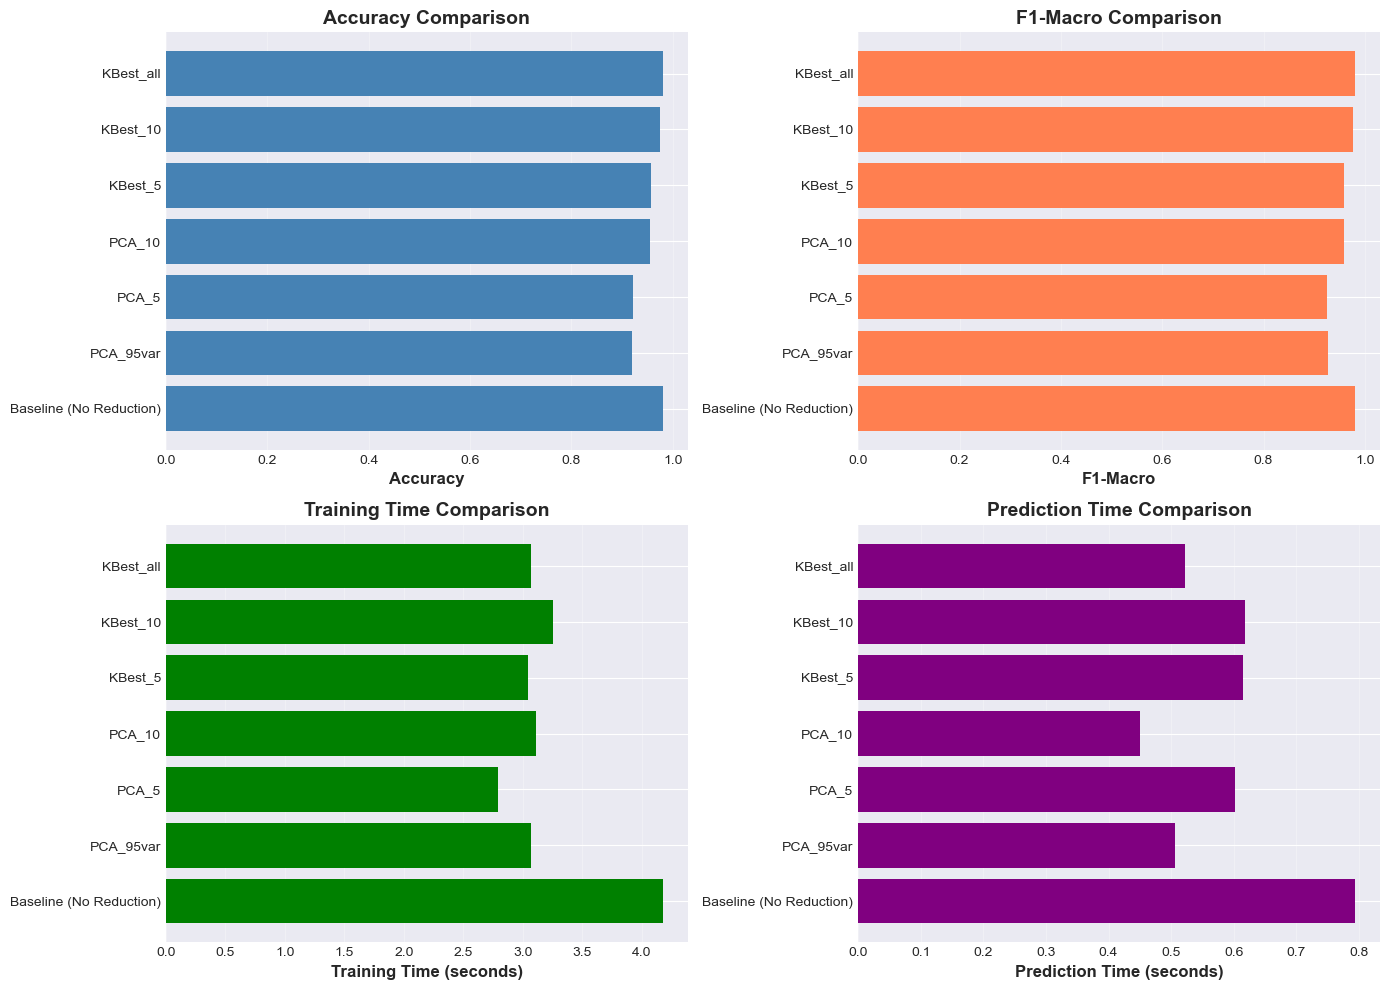

✓ Dimensionality reduction comparison plots saved


In [22]:
# Compare baseline vs dimensionality reduction methods
comparison_data = [
    {
        'Method': 'Baseline (No Reduction)',
        'N_Components': X_train.shape[1],
        'Accuracy': accuracy_rf,
        'F1_Macro': f1_macro_rf,
        'Train_Time': training_time_rf,
        'Pred_Time': prediction_time_rf
    }
]

comparison_data.extend(pca_results)
comparison_data.extend(kbest_results)

dim_reduction_comparison = pd.DataFrame(comparison_data)

print("="*60)
print("DIMENSIONALITY REDUCTION COMPARISON")
print("="*60)
display(dim_reduction_comparison.round(4))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy comparison
axes[0, 0].barh(dim_reduction_comparison['Method'], dim_reduction_comparison['Accuracy'], color='steelblue')
axes[0, 0].set_xlabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# F1-Macro comparison
axes[0, 1].barh(dim_reduction_comparison['Method'], dim_reduction_comparison['F1_Macro'], color='coral')
axes[0, 1].set_xlabel('F1-Macro', fontsize=12, fontweight='bold')
axes[0, 1].set_title('F1-Macro Comparison', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# Training time comparison
axes[1, 0].barh(dim_reduction_comparison['Method'], dim_reduction_comparison['Train_Time'], color='green')
axes[1, 0].set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# Prediction time comparison
axes[1, 1].barh(dim_reduction_comparison['Method'], dim_reduction_comparison['Pred_Time'], color='purple')
axes[1, 1].set_xlabel('Prediction Time (seconds)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Prediction Time Comparison', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/dimensionality_reduction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Dimensionality reduction comparison plots saved")


## 5. Comparison with Other Classifiers

### 5.1 Decision Tree Classifier


In [23]:
# Create Decision Tree pipeline
dt_pipeline = Pipeline([
    ('preproc', preprocessing_pipeline),
    ('clf', DecisionTreeClassifier(random_state=RND))
])

# Define hyperparameter grid for Decision Tree
param_grid_dt = {
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_leaf': [1, 2, 4]
}

print("=" * 60)
print("DECISION TREE HYPERPARAMETER TUNING")
print("=" * 60)

# Perform grid search
start_time = time.time()
grid_search_dt = GridSearchCV(
    dt_pipeline,
    param_grid_dt,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search_dt.fit(X_train, y_train)
tuning_time_dt = time.time() - start_time

print(f"\n✓ GridSearchCV completed in {tuning_time_dt:.2f} seconds")
print(f"\nBest parameters:")
for param, value in grid_search_dt.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV score: {grid_search_dt.best_score_:.4f}")

# Train final model
start_time = time.time()
final_dt_model = grid_search_dt.best_estimator_
final_dt_model.fit(X_train, y_train)
training_time_dt = time.time() - start_time

print(f"\n✓ Model trained in {training_time_dt:.2f} seconds")

# Cross-validated performance
cv_scores_dt_acc = cross_val_score(final_dt_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
cv_scores_dt_f1 = cross_val_score(final_dt_model, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)

print(f"\nCV Accuracy: {cv_scores_dt_acc.mean():.4f} (+/- {cv_scores_dt_acc.std() * 2:.4f})")
print(f"CV Macro F1: {cv_scores_dt_f1.mean():.4f} (+/- {cv_scores_dt_f1.std() * 2:.4f})")


DECISION TREE HYPERPARAMETER TUNING
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✓ GridSearchCV completed in 14.39 seconds

Best parameters:
  clf__max_depth: None
  clf__min_samples_leaf: 1

Best CV score: 0.8568

✓ Model trained in 0.33 seconds

CV Accuracy: 0.8568 (+/- 0.0270)
CV Macro F1: 0.8602 (+/- 0.0257)


In [24]:
# Evaluate Decision Tree on test set
start_time = time.time()
y_pred_dt = final_dt_model.predict(X_test)
prediction_time_dt = time.time() - start_time

y_pred_proba_dt = final_dt_model.predict_proba(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_macro_dt = precision_score(y_test, y_pred_dt, average='macro', zero_division=0)
recall_macro_dt = recall_score(y_test, y_pred_dt, average='macro', zero_division=0)
f1_macro_dt = f1_score(y_test, y_pred_dt, average='macro', zero_division=0)

print("=" * 60)
print("TEST SET EVALUATION - DECISION TREE")
print("=" * 60)
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision (macro): {precision_macro_dt:.4f}")
print(f"Recall (macro): {recall_macro_dt:.4f}")
print(f"F1-score (macro): {f1_macro_dt:.4f}")
print(f"Prediction time: {prediction_time_dt:.4f} seconds")

# Compute ROC-AUC for Decision Tree
fpr_dt = dict()
tpr_dt = dict()
roc_auc_dt = dict()

for i in range(n_classes):
    fpr_dt[i], tpr_dt[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_dt[:, i])
    roc_auc_dt[i] = auc(fpr_dt[i], tpr_dt[i])

fpr_dt["micro"], tpr_dt["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba_dt.ravel())
roc_auc_dt["micro"] = auc(fpr_dt["micro"], tpr_dt["micro"])

all_fpr_dt = np.unique(np.concatenate([fpr_dt[i] for i in range(n_classes)]))
mean_tpr_dt = np.zeros_like(all_fpr_dt)
for i in range(n_classes):
    mean_tpr_dt += np.interp(all_fpr_dt, fpr_dt[i], tpr_dt[i])
mean_tpr_dt /= n_classes
fpr_dt["macro"] = all_fpr_dt
tpr_dt["macro"] = mean_tpr_dt
roc_auc_dt["macro"] = auc(fpr_dt["macro"], tpr_dt["macro"])

print(f"\nMacro-average AUC: {roc_auc_dt['macro']:.4f}")
print(f"Micro-average AUC: {roc_auc_dt['micro']:.4f}")


TEST SET EVALUATION - DECISION TREE
Accuracy: 0.8886
Precision (macro): 0.8873
Recall (macro): 0.8943
F1-score (macro): 0.8904
Prediction time: 0.0140 seconds

Macro-average AUC: 0.9409
Micro-average AUC: 0.9381


### 5.2 K-Nearest Neighbors (KNN) Classifier


In [25]:
# Create KNN pipeline
knn_pipeline = Pipeline([
    ('preproc', preprocessing_pipeline),
    ('clf', KNeighborsClassifier(n_jobs=-1))
])

# Define hyperparameter grid for KNN
param_grid_knn = {
    'clf__n_neighbors': [3, 5, 7, 9],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2]  # 1=Manhattan, 2=Euclidean
}

print("=" * 60)
print("KNN HYPERPARAMETER TUNING")
print("=" * 60)

# Perform grid search
start_time = time.time()
grid_search_knn = GridSearchCV(
    knn_pipeline,
    param_grid_knn,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search_knn.fit(X_train, y_train)
tuning_time_knn = time.time() - start_time

print(f"\n✓ GridSearchCV completed in {tuning_time_knn:.2f} seconds")
print(f"\nBest parameters:")
for param, value in grid_search_knn.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV score: {grid_search_knn.best_score_:.4f}")

# Train final model
start_time = time.time()
final_knn_model = grid_search_knn.best_estimator_
final_knn_model.fit(X_train, y_train)
training_time_knn = time.time() - start_time

print(f"\n✓ Model trained in {training_time_knn:.2f} seconds")

# Cross-validated performance
cv_scores_knn_acc = cross_val_score(final_knn_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
cv_scores_knn_f1 = cross_val_score(final_knn_model, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)

print(f"\nCV Accuracy: {cv_scores_knn_acc.mean():.4f} (+/- {cv_scores_knn_acc.std() * 2:.4f})")
print(f"CV Macro F1: {cv_scores_knn_f1.mean():.4f} (+/- {cv_scores_knn_f1.std() * 2:.4f})")


KNN HYPERPARAMETER TUNING
Fitting 5 folds for each of 16 candidates, totalling 80 fits

✓ GridSearchCV completed in 3.09 seconds

Best parameters:
  clf__n_neighbors: 3
  clf__p: 1
  clf__weights: distance

Best CV score: 0.9628

✓ Model trained in 0.03 seconds

CV Accuracy: 0.9628 (+/- 0.0081)
CV Macro F1: 0.9645 (+/- 0.0090)


In [26]:
# Evaluate KNN on test set
start_time = time.time()
y_pred_knn = final_knn_model.predict(X_test)
prediction_time_knn = time.time() - start_time

y_pred_proba_knn = final_knn_model.predict_proba(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_macro_knn = precision_score(y_test, y_pred_knn, average='macro', zero_division=0)
recall_macro_knn = recall_score(y_test, y_pred_knn, average='macro', zero_division=0)
f1_macro_knn = f1_score(y_test, y_pred_knn, average='macro', zero_division=0)

print("=" * 60)
print("TEST SET EVALUATION - KNN")
print("=" * 60)
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision (macro): {precision_macro_knn:.4f}")
print(f"Recall (macro): {recall_macro_knn:.4f}")
print(f"F1-score (macro): {f1_macro_knn:.4f}")
print(f"Prediction time: {prediction_time_knn:.4f} seconds")

# Compute ROC-AUC for KNN
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()

for i in range(n_classes):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

fpr_knn["micro"], tpr_knn["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba_knn.ravel())
roc_auc_knn["micro"] = auc(fpr_knn["micro"], tpr_knn["micro"])

all_fpr_knn = np.unique(np.concatenate([fpr_knn[i] for i in range(n_classes)]))
mean_tpr_knn = np.zeros_like(all_fpr_knn)
for i in range(n_classes):
    mean_tpr_knn += np.interp(all_fpr_knn, fpr_knn[i], tpr_knn[i])
mean_tpr_knn /= n_classes
fpr_knn["macro"] = all_fpr_knn
tpr_knn["macro"] = mean_tpr_knn
roc_auc_knn["macro"] = auc(fpr_knn["macro"], tpr_knn["macro"])

print(f"\nMacro-average AUC: {roc_auc_knn['macro']:.4f}")
print(f"Micro-average AUC: {roc_auc_knn['micro']:.4f}")


TEST SET EVALUATION - KNN
Accuracy: 0.9734
Precision (macro): 0.9718
Recall (macro): 0.9790
F1-score (macro): 0.9752
Prediction time: 0.0700 seconds

Macro-average AUC: 0.9960
Micro-average AUC: 0.9949


### 5.3 Model Comparison


In [27]:
# Compile comparison results
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'KNN'],
    'CV_Accuracy_Mean': [
        cv_scores_accuracy.mean(),
        cv_scores_dt_acc.mean(),
        cv_scores_knn_acc.mean()
    ],
    'CV_Accuracy_Std': [
        cv_scores_accuracy.std(),
        cv_scores_dt_acc.std(),
        cv_scores_knn_acc.std()
    ],
    'CV_F1_Macro_Mean': [
        cv_scores_f1_macro.mean(),
        cv_scores_dt_f1.mean(),
        cv_scores_knn_f1.mean()
    ],
    'CV_F1_Macro_Std': [
        cv_scores_f1_macro.std(),
        cv_scores_dt_f1.std(),
        cv_scores_knn_f1.std()
    ],
    'Test_Accuracy': [accuracy_rf, accuracy_dt, accuracy_knn],
    'Test_Precision_Macro': [precision_macro_rf, precision_macro_dt, precision_macro_knn],
    'Test_Recall_Macro': [recall_macro_rf, recall_macro_dt, recall_macro_knn],
    'Test_F1_Macro': [f1_macro_rf, f1_macro_dt, f1_macro_knn],
    'Test_ROC_AUC_Macro': [roc_auc['macro'], roc_auc_dt['macro'], roc_auc_knn['macro']],
    'Training_Time': [training_time_rf, training_time_dt, training_time_knn],
    'Prediction_Time': [prediction_time_rf, prediction_time_dt, prediction_time_knn]
})

print("=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
display(model_comparison.round(4))


MODEL COMPARISON SUMMARY


,Model,CV_Accuracy_Mean,CV_Accuracy_Std,CV_F1_Macro_Mean,CV_F1_Macro_Std,Test_Accuracy,Test_Precision_Macro,Test_Recall_Macro,Test_F1_Macro,Test_ROC_AUC_Macro,Training_Time,Prediction_Time
0,Random Forest,0.9740,0.0030,0.9759,0.0033,0.9799,0.9786,0.9834,0.9809,0.9998,4.1739,0.7941
1,Decision Tree,0.8568,0.0135,0.8602,0.0128,0.8886,0.8873,0.8943,0.8904,0.9409,0.3296,0.0140
2,KNN,0.9628,0.0041,0.9645,0.0045,0.9734,0.9718,0.9790,0.9752,0.9960,0.0338,0.0700


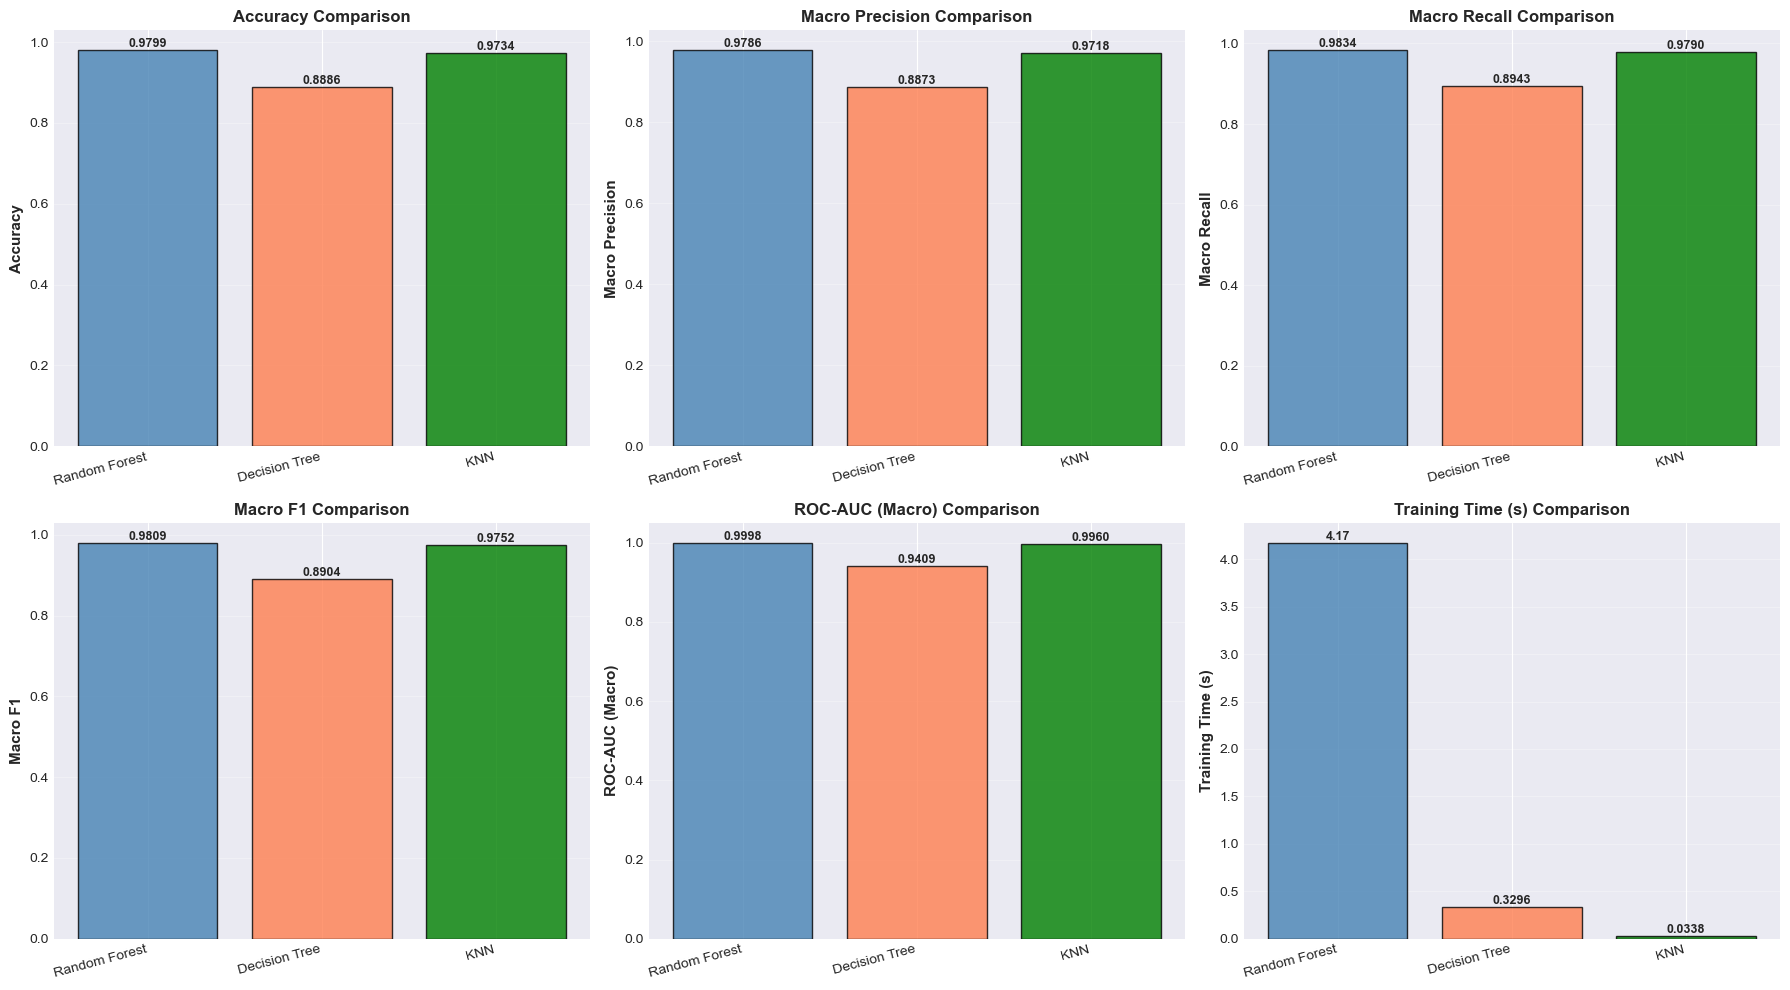

✓ Model comparison plots saved


In [28]:
# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

models = ['Random Forest', 'Decision Tree', 'KNN']
metrics = {
    'Accuracy': [accuracy_rf, accuracy_dt, accuracy_knn],
    'Macro Precision': [precision_macro_rf, precision_macro_dt, precision_macro_knn],
    'Macro Recall': [recall_macro_rf, recall_macro_dt, recall_macro_knn],
    'Macro F1': [f1_macro_rf, f1_macro_dt, f1_macro_knn],
    'ROC-AUC (Macro)': [roc_auc['macro'], roc_auc_dt['macro'], roc_auc_knn['macro']],
    'Training Time (s)': [training_time_rf, training_time_dt, training_time_knn]
}

colors_bar = ['steelblue', 'coral', 'green']
x_pos = np.arange(len(models))

for idx, (metric_name, values) in enumerate(metrics.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    bars = ax.bar(x_pos, values, color=colors_bar, alpha=0.8, edgecolor='black')
    ax.set_ylabel(metric_name, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric_name} Comparison', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models, rotation=15, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}' if val < 1 else f'{val:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Model comparison plots saved")


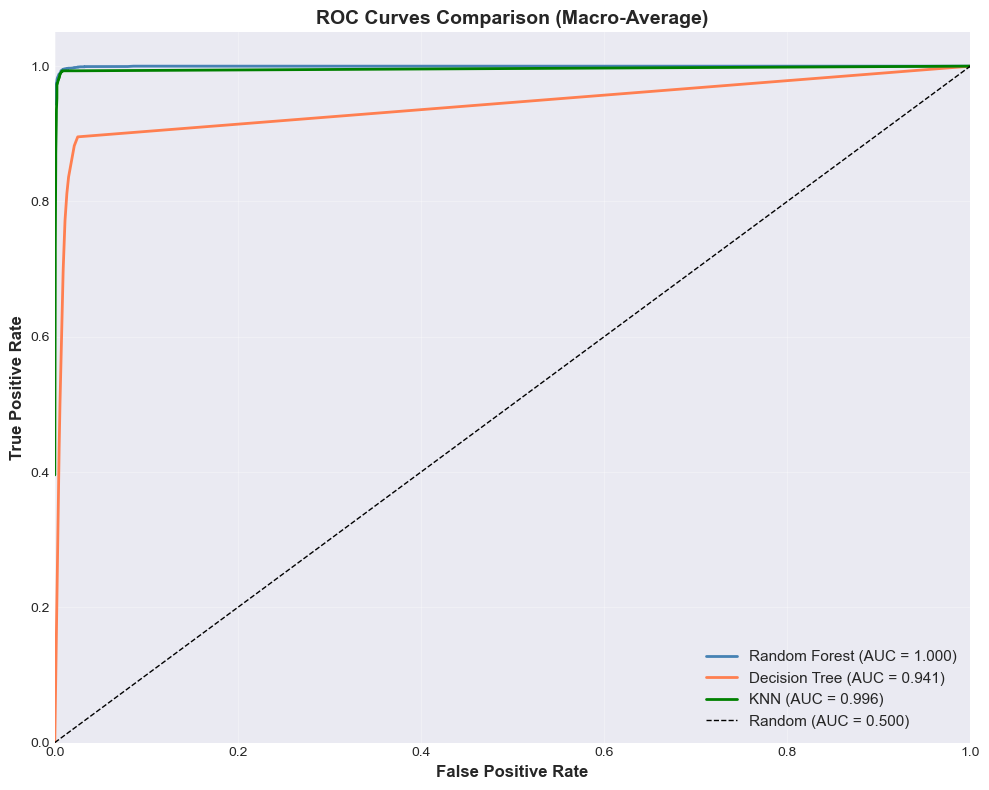

✓ ROC curves comparison plot saved


In [29]:
# Plot ROC curves comparison
fig, ax = plt.subplots(figsize=(10, 8))

# Random Forest
ax.plot(fpr["macro"], tpr["macro"],
        label=f'Random Forest (AUC = {roc_auc["macro"]:.3f})',
        color='steelblue', linewidth=2)

# Decision Tree
ax.plot(fpr_dt["macro"], tpr_dt["macro"],
        label=f'Decision Tree (AUC = {roc_auc_dt["macro"]:.3f})',
        color='coral', linewidth=2)

# KNN
ax.plot(fpr_knn["macro"], tpr_knn["macro"],
        label=f'KNN (AUC = {roc_auc_knn["macro"]:.3f})',
        color='green', linewidth=2)

# Diagonal line
ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.500)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves Comparison (Macro-Average)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC curves comparison plot saved")


## 6. Model Interpretability

### 6.1 Random Forest Feature Importance


TOP 20 FEATURE IMPORTANCES - RANDOM FOREST


,Feature,Importance
6,Average_R,0.105544
13,Skewness,0.078480
12,Kurtosis,0.077071
0,Entropy,0.075376
8,Average_B,0.073948
9,Mean,0.072664
2,Energy,0.071018
10,Std Dev,0.068449
11,Variance,0.067681
7,Average_G,0.067525


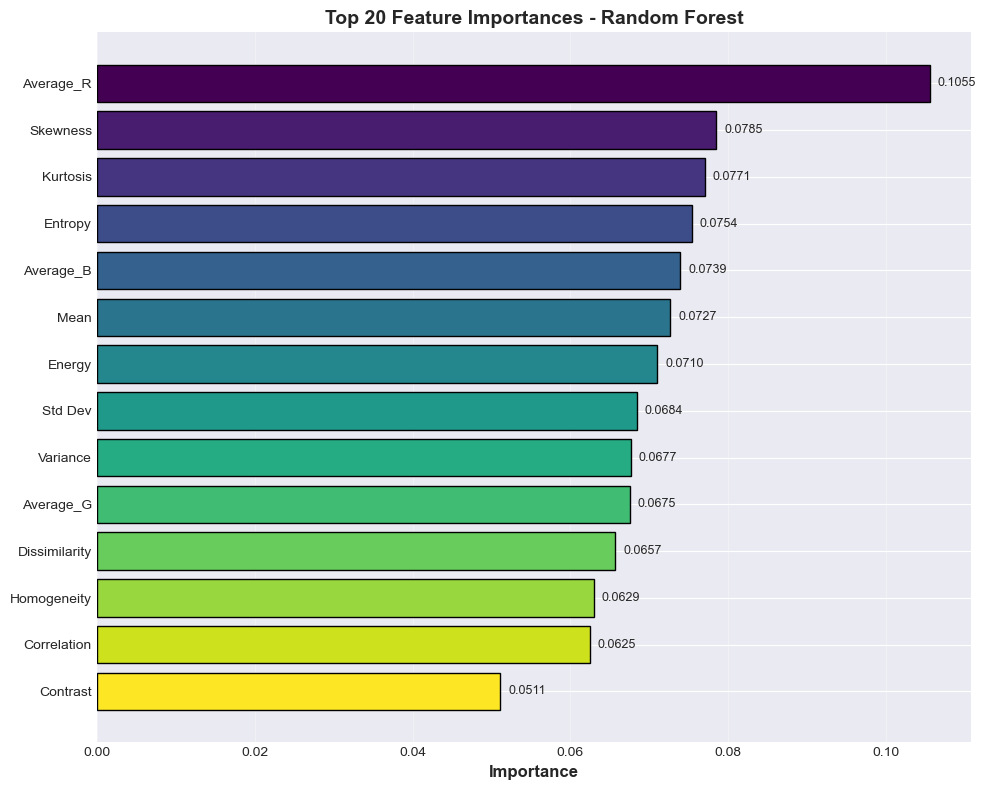

✓ Feature importance plot saved


In [30]:
# Extract feature importances from Random Forest
feature_importances = final_rf_model.named_steps['clf'].feature_importances_
feature_names = X_train.columns

# Create DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("=" * 60)
print("TOP 20 FEATURE IMPORTANCES - RANDOM FOREST")
print("=" * 60)
display(importance_df.head(20))

# Plot top 20 feature importances
fig, ax = plt.subplots(figsize=(10, 8))
top_20 = importance_df.head(20)
colors_imp = plt.cm.viridis(np.linspace(0, 1, len(top_20)))

bars = ax.barh(range(len(top_20)), top_20['Importance'], color=colors_imp, edgecolor='black')
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['Feature'], fontsize=10)
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_20.iterrows()):
    ax.text(row['Importance'] + 0.001, i, f"{row['Importance']:.4f}",
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/feature_importances_rf.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature importance plot saved")


### 6.2 Decision Tree Visualization


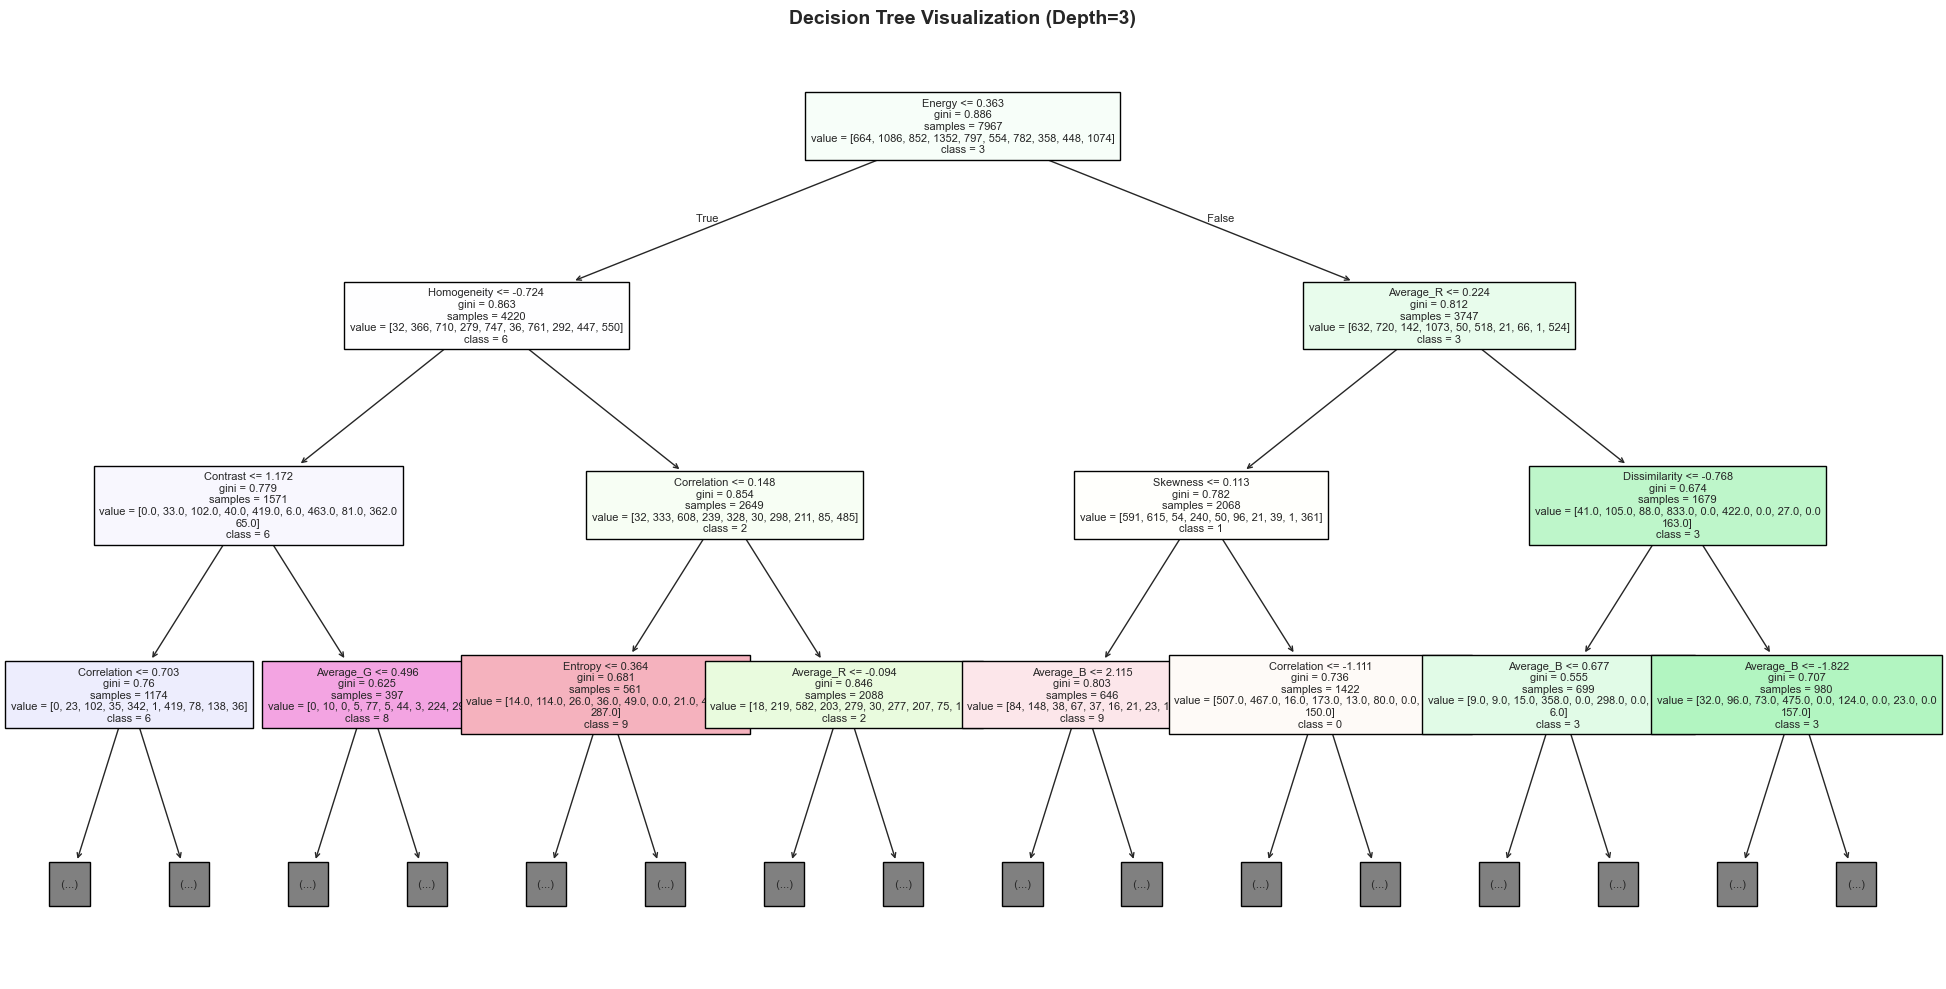

✓ Decision tree visualization saved

DECISION TREE TEXT REPRESENTATION (First 500 chars)
|--- Energy <= 0.36
|   |--- Homogeneity <= -0.72
|   |   |--- Contrast <= 1.17
|   |   |   |--- Correlation <= 0.70
|   |   |   |   |--- truncated branch of depth 15
|   |   |   |--- Correlation >  0.70
|   |   |   |   |--- truncated branch of depth 11
|   |   |--- Contrast >  1.17
|   |   |   |--- Average_G <= 0.50
|   |   |   |   |--- truncated branch of depth 9
|   |   |   |--- Average_G >  0.50
|   |   |   |   |--- truncated branch of depth 13
|   |--- Homogeneity >  -0.72
|   |   |--- Corr...


In [31]:
# Visualize Decision Tree (limited depth for readability)
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(final_dt_model.named_steps['clf'], 
          max_depth=3,
          feature_names=X_train.columns,
          class_names=[str(i) for i in range(10)],
          filled=True,
          fontsize=8,
          ax=ax)
plt.title('Decision Tree Visualization (Depth=3)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/decision_tree_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Decision tree visualization saved")

# Also export text representation
print("\n" + "="*60)
print("DECISION TREE TEXT REPRESENTATION (First 500 chars)")
print("="*60)
from sklearn.tree import export_text
tree_rules = export_text(final_dt_model.named_steps['clf'], 
                        feature_names=list(X_train.columns),
                        max_depth=3)
print(tree_rules[:500] + "..." if len(tree_rules) > 500 else tree_rules)


## 7. Learning Curves


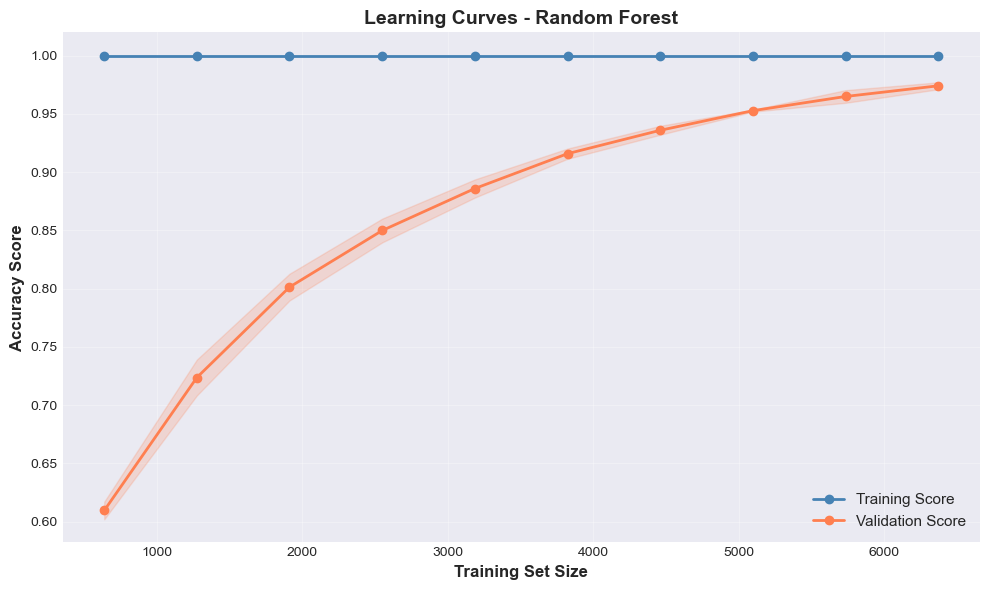

✓ Learning curves plot saved

Final training score: 1.0000 (+/- 0.0000)
Final validation score: 0.9740 (+/- 0.0030)
Gap (overfitting indicator): 0.0260


In [32]:
# Generate learning curves for Random Forest
train_sizes, train_scores, val_scores = learning_curve(
    final_rf_model,
    X_train,
    y_train,
    cv=cv,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_sizes, train_mean, 'o-', color='steelblue', label='Training Score', linewidth=2)
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='steelblue')
ax.plot(train_sizes, val_mean, 'o-', color='coral', label='Validation Score', linewidth=2)
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='coral')

ax.set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy Score', fontsize=12, fontweight='bold')
ax.set_title('Learning Curves - Random Forest', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/learning_curves_rf.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Learning curves plot saved")
print(f"\nFinal training score: {train_mean[-1]:.4f} (+/- {train_std[-1]:.4f})")
print(f"Final validation score: {val_mean[-1]:.4f} (+/- {val_std[-1]:.4f})")
print(f"Gap (overfitting indicator): {train_mean[-1] - val_mean[-1]:.4f}")


## 8. PCA 2D Visualization


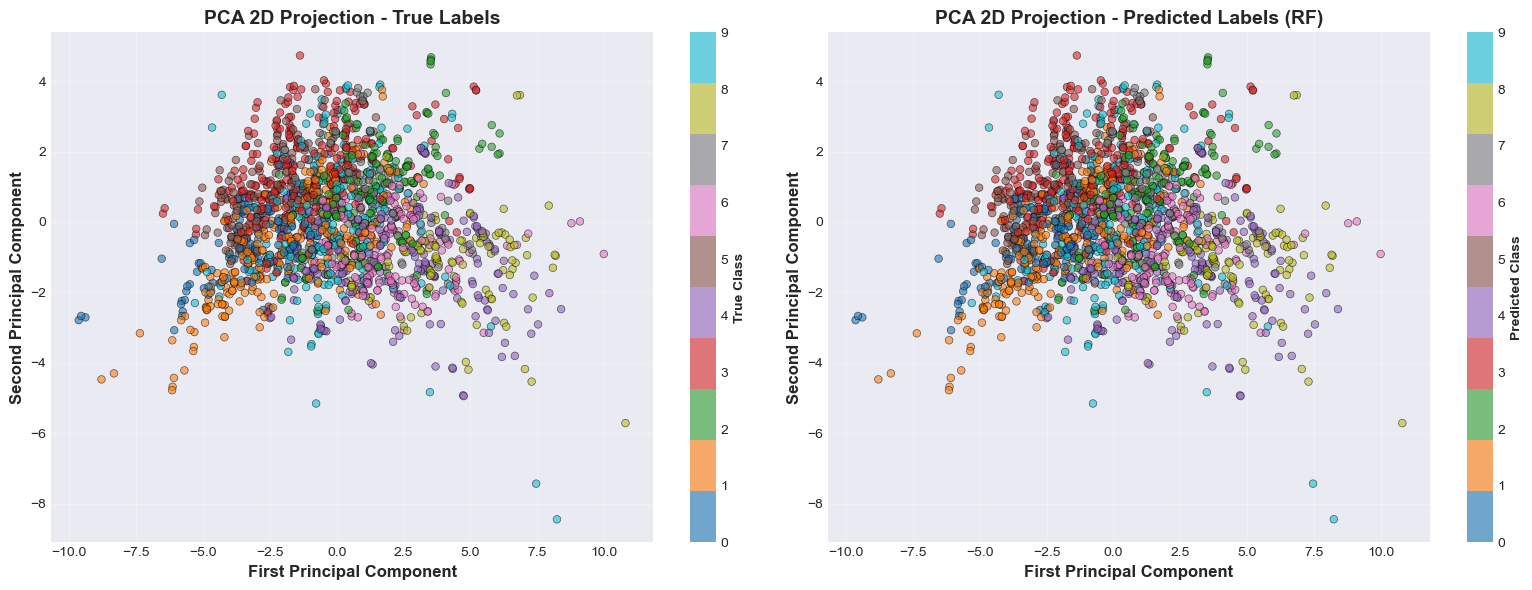

✓ PCA 2D scatter plots saved

Explained variance by PC1: 0.5466
Explained variance by PC2: 0.1823
Total explained variance (2D): 0.7289


In [33]:
# Project test set onto first two principal components
pca_2d = PCA(n_components=2)
X_test_scaled = preprocessing_pipeline.transform(X_test)
X_test_pca_2d = pca_2d.fit_transform(X_test_scaled)

# Get predictions for coloring
y_pred_rf_2d = loaded_model.predict(X_test)

# Create scatter plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot with true labels
scatter1 = axes[0].scatter(X_test_pca_2d[:, 0], X_test_pca_2d[:, 1], 
                          c=y_test, cmap='tab10', alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('First Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Second Principal Component', fontsize=12, fontweight='bold')
axes[0].set_title('PCA 2D Projection - True Labels', fontsize=14, fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('True Class', fontsize=10, fontweight='bold')
axes[0].grid(alpha=0.3)

# Plot with predicted labels
scatter2 = axes[1].scatter(X_test_pca_2d[:, 0], X_test_pca_2d[:, 1], 
                          c=y_pred_rf_2d, cmap='tab10', alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('First Principal Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Second Principal Component', fontsize=12, fontweight='bold')
axes[1].set_title('PCA 2D Projection - Predicted Labels (RF)', fontsize=14, fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Predicted Class', fontsize=10, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/pca_2d_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ PCA 2D scatter plots saved")
print(f"\nExplained variance by PC1: {pca_2d.explained_variance_ratio_[0]:.4f}")
print(f"Explained variance by PC2: {pca_2d.explained_variance_ratio_[1]:.4f}")
print(f"Total explained variance (2D): {pca_2d.explained_variance_ratio_.sum():.4f}")


## 9. Computational Efficiency Analysis


COMPUTATIONAL EFFICIENCY ANALYSIS


,Model,Training_Time_s,Prediction_Time_s,Prediction_Time_per_Sample_ms,Model_Size_MB
0,Random Forest,4.1739,0.7941,0.3986,163.7485
1,Decision Tree,0.3296,0.0140,0.0070,0.0000
2,KNN,0.0338,0.0700,0.0351,0.0000


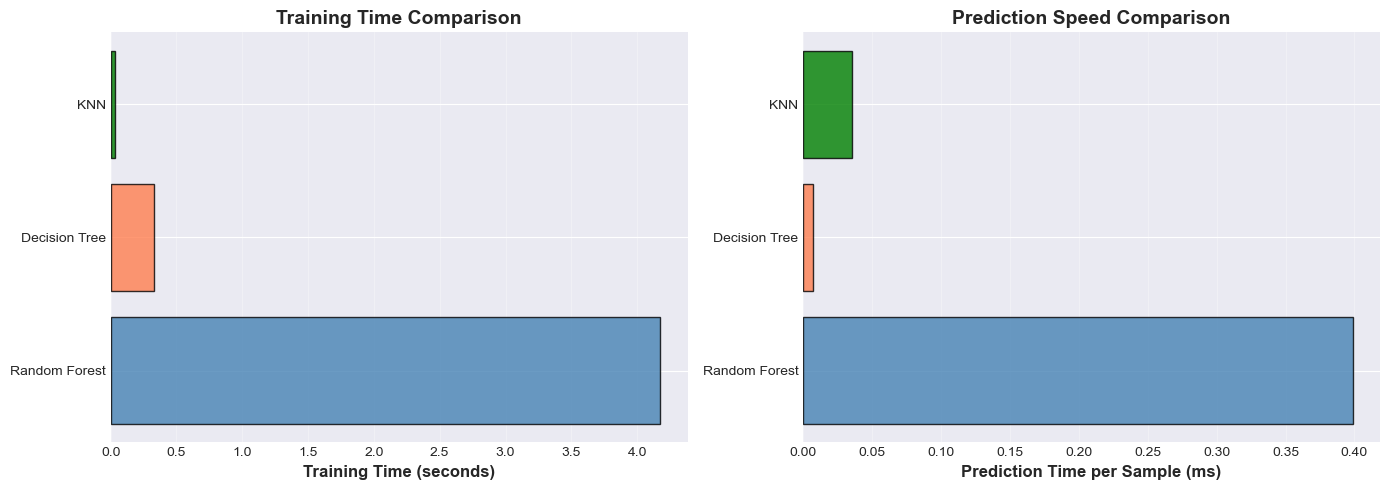

✓ Computational efficiency plots saved

✓ Model file size: 163.75 MB


In [34]:
# Compile efficiency metrics
efficiency_df = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'KNN'],
    'Training_Time_s': [training_time_rf, training_time_dt, training_time_knn],
    'Prediction_Time_s': [prediction_time_rf, prediction_time_dt, prediction_time_knn],
    'Prediction_Time_per_Sample_ms': [
        prediction_time_rf / len(X_test) * 1000,
        prediction_time_dt / len(X_test) * 1000,
        prediction_time_knn / len(X_test) * 1000
    ]
})

# Check model file sizes
import os
model_files = {
    'Random Forest': MODEL_PATH
}
if os.path.exists(MODEL_PATH):
    model_files['Random Forest'] = os.path.getsize(MODEL_PATH) / (1024 * 1024)  # MB
else:
    model_files['Random Forest'] = 0

# Add file sizes (approximate for DT and KNN - they're not saved)
efficiency_df['Model_Size_MB'] = [
    model_files.get('Random Forest', 0),
    0,  # Decision Tree not saved
    0   # KNN not saved
]

print("=" * 60)
print("COMPUTATIONAL EFFICIENCY ANALYSIS")
print("=" * 60)
display(efficiency_df.round(4))

# Visualize efficiency
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(efficiency_df['Model'], efficiency_df['Training_Time_s'], 
             color=['steelblue', 'coral', 'green'], alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
axes[0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(efficiency_df['Model'], efficiency_df['Prediction_Time_per_Sample_ms'],
             color=['steelblue', 'coral', 'green'], alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Prediction Time per Sample (ms)', fontsize=12, fontweight='bold')
axes[1].set_title('Prediction Speed Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/computational_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Computational efficiency plots saved")
if os.path.exists(MODEL_PATH):
    print(f"\n✓ Model file size: {os.path.getsize(MODEL_PATH) / (1024 * 1024):.2f} MB")


## 10. Summary and Final Results

### 10.1 Complete Results Table


In [35]:
# Create comprehensive results summary
final_results = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'KNN'],
    'CV_Accuracy_Mean': [
        f"{cv_scores_accuracy.mean():.4f}",
        f"{cv_scores_dt_acc.mean():.4f}",
        f"{cv_scores_knn_acc.mean():.4f}"
    ],
    'CV_Accuracy_Std': [
        f"±{cv_scores_accuracy.std():.4f}",
        f"±{cv_scores_dt_acc.std():.4f}",
        f"±{cv_scores_knn_acc.std():.4f}"
    ],
    'CV_F1_Macro_Mean': [
        f"{cv_scores_f1_macro.mean():.4f}",
        f"{cv_scores_dt_f1.mean():.4f}",
        f"{cv_scores_knn_f1.mean():.4f}"
    ],
    'Test_Accuracy': [
        f"{accuracy_rf:.4f}",
        f"{accuracy_dt:.4f}",
        f"{accuracy_knn:.4f}"
    ],
    'Test_F1_Macro': [
        f"{f1_macro_rf:.4f}",
        f"{f1_macro_dt:.4f}",
        f"{f1_macro_knn:.4f}"
    ],
    'Test_ROC_AUC_Macro': [
        f"{roc_auc['macro']:.4f}",
        f"{roc_auc_dt['macro']:.4f}",
        f"{roc_auc_knn['macro']:.4f}"
    ],
    'Training_Time_s': [
        f"{training_time_rf:.2f}",
        f"{training_time_dt:.2f}",
        f"{training_time_knn:.2f}"
    ],
    'Prediction_Time_s': [
        f"{prediction_time_rf:.4f}",
        f"{prediction_time_dt:.4f}",
        f"{prediction_time_knn:.4f}"
    ]
})

print("=" * 80)
print("FINAL RESULTS SUMMARY")
print("=" * 80)
display(final_results)

print("\n" + "=" * 80)
print("BEST MODEL SELECTION")
print("=" * 80)
print(f"Best Test Accuracy: {final_results.loc[final_results['Test_Accuracy'].str.replace('.', '').astype(float).idxmax(), 'Model']}")
print(f"Best Test F1-Macro: {final_results.loc[final_results['Test_F1_Macro'].str.replace('.', '').astype(float).idxmax(), 'Model']}")
print(f"Best ROC-AUC: {final_results.loc[final_results['Test_ROC_AUC_Macro'].str.replace('.', '').astype(float).idxmax(), 'Model']}")
print(f"\n✓ Primary model (Random Forest) saved to: {MODEL_PATH}")


FINAL RESULTS SUMMARY


,Model,CV_Accuracy_Mean,CV_Accuracy_Std,CV_F1_Macro_Mean,Test_Accuracy,Test_F1_Macro,Test_ROC_AUC_Macro,Training_Time_s,Prediction_Time_s
0,Random Forest,0.9740,±0.0030,0.9759,0.9799,0.9809,0.9998,4.17,0.7941
1,Decision Tree,0.8568,±0.0135,0.8602,0.8886,0.8904,0.9409,0.33,0.0140
2,KNN,0.9628,±0.0041,0.9645,0.9734,0.9752,0.9960,0.03,0.0700



BEST MODEL SELECTION
Best Test Accuracy: Random Forest
Best Test F1-Macro: Random Forest
Best ROC-AUC: Random Forest

✓ Primary model (Random Forest) saved to: model_1.pkl


---

## End of Notebook

**Deliverables:**
- ✓ `model_1.pkl` - Trained Random Forest model
- ✓ All visualizations saved to `figures/` directory
- ✓ Comprehensive evaluation and comparison complete

**Next Steps:**
- Generate detailed report (see report_question1.md)
- Review class-wise performance for insights
- Consider ensemble methods or further hyperparameter optimization
